In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Introduction to Diffusion Imaging in Python (DIPY) 

OHBM 2018 Educational Course 

Kesshi Jordan


University of California, San Francisco


**Contact**: email: [kesshi.jordan@gmail.com](mailto:kesshi.jordan@gmail.com) , Twitter: [@keshjordan\_](https://twitter.com/keshjordan)

# Introduction

## Set Up:
2 ways to set up:
    
1. If you have a Python environment set up on your computer: 
    
        git clone https://github.com/kesshijordan/dipy_workshop.git
        cd dipy_workshop
        conda install -c conda-forge dipy
        pip install vtk
        pip install nilearn
        jupyter notebook

2. Go to https://notebooks.azure.com/nb/notebookskesshij/libraries/ , sign in, and click `clone`

![](colabInstructions.png)

### How to use this notebook

* Hit Shift + Enter on your keyboard to run each cell
* If you want help on a function, type a question mark `?` after the function to get more documentation

## Background

This starts with a version of the Dipy Tracking Quickstart Tutorial (http://nipy.org/dipy/examples_built/tracking_quick_start.html#example-tracking-quick-start) for beginners to python. 

We then cluster our results using Quickbundles (http://nipy.org/dipy/examples_built/segment_quickbundles.html#example-segment-quickbundles).

NOTE: For this tutorial, we assume you have eddy-corrected (https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/eddy) (and if you can susceptibility-corrected; https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/topup) your data

For more examples:
http://nipy.org/dipy/examples_index.html

# Download and Load our data 

In [3]:
from dipy.data import fetch_stanford_hardi, read_stanford_hardi
fetch_stanford_hardi()
img, gtab = read_stanford_hardi()

Dataset is already in place. If you want to fetch it again please first remove the folder /Users/kesshijordan/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /Users/kesshijordan/.dipy/stanford_hardi 


In [4]:
data = img.get_data()

Let's check and see if our files match our expectations

In [5]:
print(data.shape)

(81, 106, 76, 160)


our data is 81 x 106 voxel resolution in-plane, 76 slices, and 160 volumes

In [6]:
print(gtab.bvals)

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000.]


... and we have our bvalues... 10 b0 volumes (no diffusion weighting) followed by 150 b2000 volumes

In [7]:
print(gtab.bvecs.shape)

(160, 3)


... and the shape of our bvecs make sense... 160 gradients by 3 dimenstions (xyz)

# Save a B0 image

Pick the first B0 image

In [8]:
import numpy as np

index_of_first_B0 = np.where(gtab.b0s_mask)[0][0]
index_of_first_B0

0

Good... we saw from our list that the first volume is a b0 image so this matches our expectation

Now let's extract the first volume from our 4-D dataset

In [9]:
b0_array = data[:,:,:,index_of_first_B0]

... and save it as a nifti

In [10]:
from dipy.io.image import save_nifti

save_nifti('ohbm_dipy_b0.nii.gz', b0_array, img.affine)

# Do a quick brain segmentation

Note: the brain segmentation default parameters don't work, so we use specific ones here. On your own data, try the defaults first

In [11]:
from dipy.segment.mask import median_otsu

maskdata, mask = median_otsu(data, 3, 2, False,
                             vol_idx=range(0, 50))

Now let's save the mask to our current directory

In [12]:
save_nifti('ohbm_dipy_mask.nii.gz', mask*1, img.affine)

Now we will use nilearn plotting to check our mask

In [13]:
import nilearn.plotting as nip

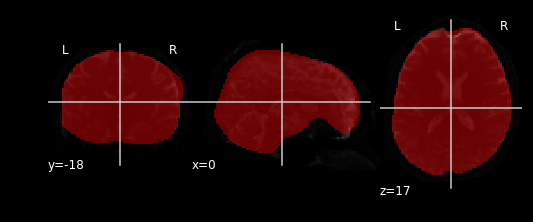

In [14]:
nip.plot_roi('ohbm_dipy_mask.nii.gz', bg_img='ohbm_dipy_b0.nii.gz', 
             cmap=nip.cm.bwr_r, alpha=0.4)

# Fit a Tensor Model

In [15]:
from dipy.reconst.dti import TensorModel

tensor_model = TensorModel(gtab, fit_method='WLS')
tensor_fit = tensor_model.fit(data, mask)

Now let's calculate fractional anisotropy (FA)

In [16]:
fa = tensor_fit.fa

# clip FA values to between 0 and 1
fa = np.clip(fa, 0, 1)

# save the nifti
save_nifti('ohbm_dipy_fa.nii.gz', fa, img.affine)

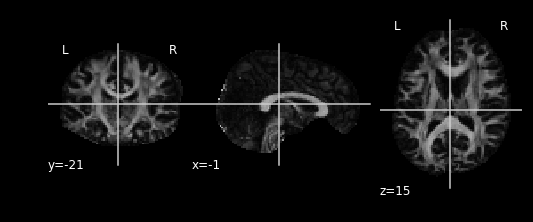

In [17]:
nip.plot_anat('ohbm_dipy_fa.nii.gz')

Now let's visualize the tensor fit using the visualization tools

In [18]:
from dipy.viz import actor, window
from dipy.reconst.dti import color_fa
from dipy.data import get_sphere

ren = window.Renderer()
rgb = color_fa(fa, tensor_fit.evecs)
    
evals = tensor_fit.evals[:,:,28:29]
evecs = tensor_fit.evecs[:, :, 28:29]
cfa = rgb[:, :, 28:29]
cfa /= cfa.max()

sphere = get_sphere('symmetric724') # we need a sphere for the render
ren.add(actor.tensor_slicer(evals, evecs, scalar_colors=cfa, 
                                sphere=sphere, scale=0.3))

# Uncomment to show this interactively
#window.show(ren)

# Save a snapshot as a png
window.record(ren, n_frames=1, out_path='ohbm_dipy_ren_ten.png', 
              size=(600, 600))



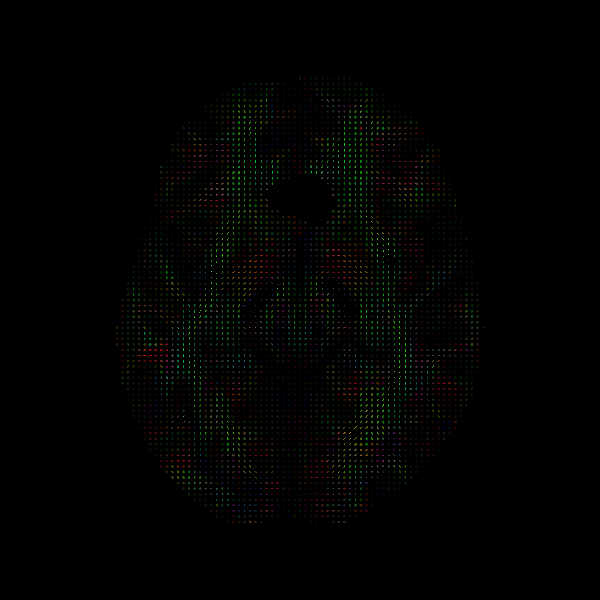

In [19]:
# this will display snapshots inline so we can see our results
from IPython.display import Image

Image('ohbm_dipy_ren_ten.png')

# Fit a "higher order" more complex model

Examples of this are :
- Constrained Spherical Deconvolution (CSD) 
- Constant Solid Angle (CSA)/QBall Model.

First, we estimate a response function for CSD...

The response function is an estimation based on the data of the signal produced by a single coherent bundle of fibers. We will use voxels with very high FA to generate this from our data.

In [20]:
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel
from dipy.reconst.csdeconv import auto_response

response, ratio = auto_response(gtab, data, roi_radius=10, fa_thr=0.7)

csd_model = ConstrainedSphericalDeconvModel(gtab, response)

# Fit the data and calculate the peaks 

(we assume these are the dominant fiber directions)

In [21]:
from dipy.direction import peaks_from_model

csd_peaks = peaks_from_model(model=csd_model,
                             data=data,
                             sphere=sphere,
                             mask=mask,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             parallel=True)

Check out our peaks on an axial slice by running this cell... a window will pop up if you uncomment window.show()


In [22]:
# Make the rendering with the peaks
window.clear(ren)
ren = window.Renderer()
ren.add(actor.peak_slicer(csd_peaks.peak_dirs,
                          csd_peaks.peak_values,colors=None))

# Uncomment this to interact with the render (a window will pop up)
#window.show(ren, size=(900, 900))

window.record(ren, out_path='ohbm_dipy_peaks.png', size=(900, 900))

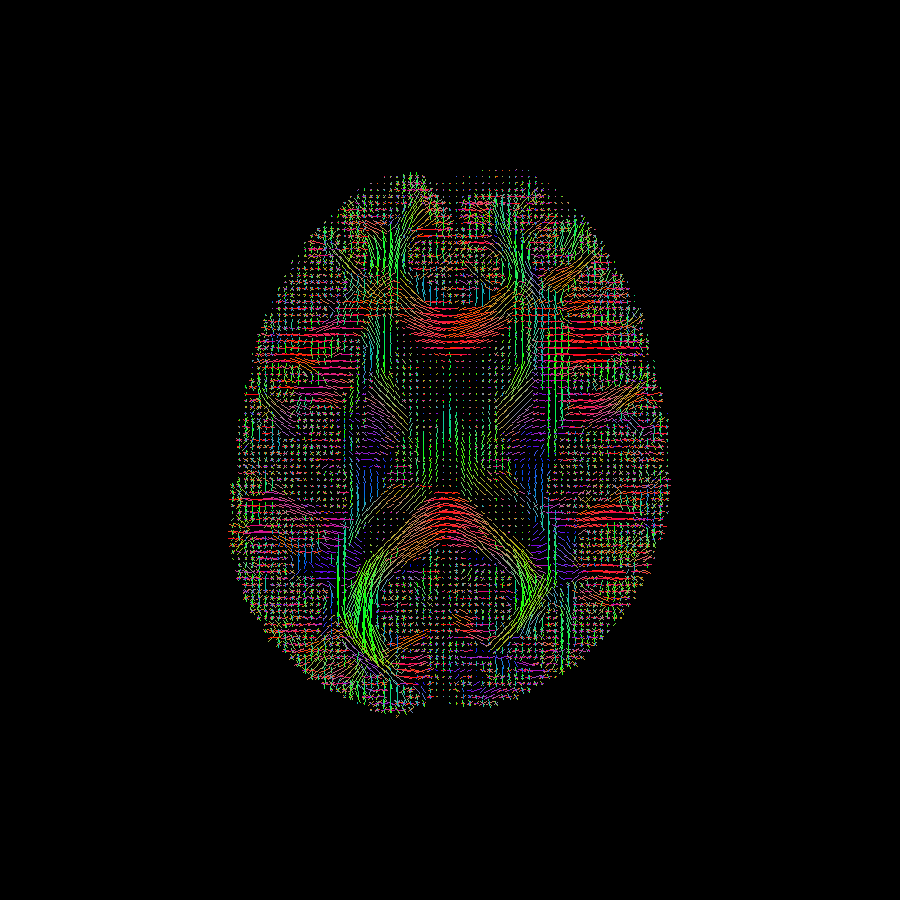

In [23]:
Image('ohbm_dipy_peaks.png')

In [24]:
window.clear(ren)

Looking at the renders... what kinds of model limitations do we encounter with the tensor model?

# Tractography!!

Make a simple tissue classifier (gray/white/csf) using FA

In [25]:
from dipy.tracking.local import ThresholdTissueClassifier

tissue_classifier = ThresholdTissueClassifier(fa, 0.15)

Generate seeds to track from in voxels with high FA... Let's seed all of the voxels with FA greater than 0.3 with one seed

In [26]:
from dipy.tracking.utils import random_seeds_from_mask

seeds = random_seeds_from_mask(fa > 0.3, seeds_count=1)

In [27]:
from dipy.tracking.local import LocalTracking
from dipy.tracking.streamline import Streamlines

streamline_generator = LocalTracking(csd_peaks, tissue_classifier,
                                     seeds, affine=np.eye(4),
                                     step_size=0.5)

streamlines = Streamlines(streamline_generator)

Now let's check how many streamlines we generated

In [28]:
print(len(streamlines))

78631


We can take a look at our streamlines now... let's write a function for this

In [29]:
def show_sls(streamlines, out_path='ohbm_dipy_streamlines.png', interact=False):    
    ren = window.Renderer()
    
    ren.add(actor.line(streamlines))

    if interact:
        window.show(ren, size=(900, 900))
    
    window.record(ren, out_path=out_path, size=(900, 900))
    return out_path

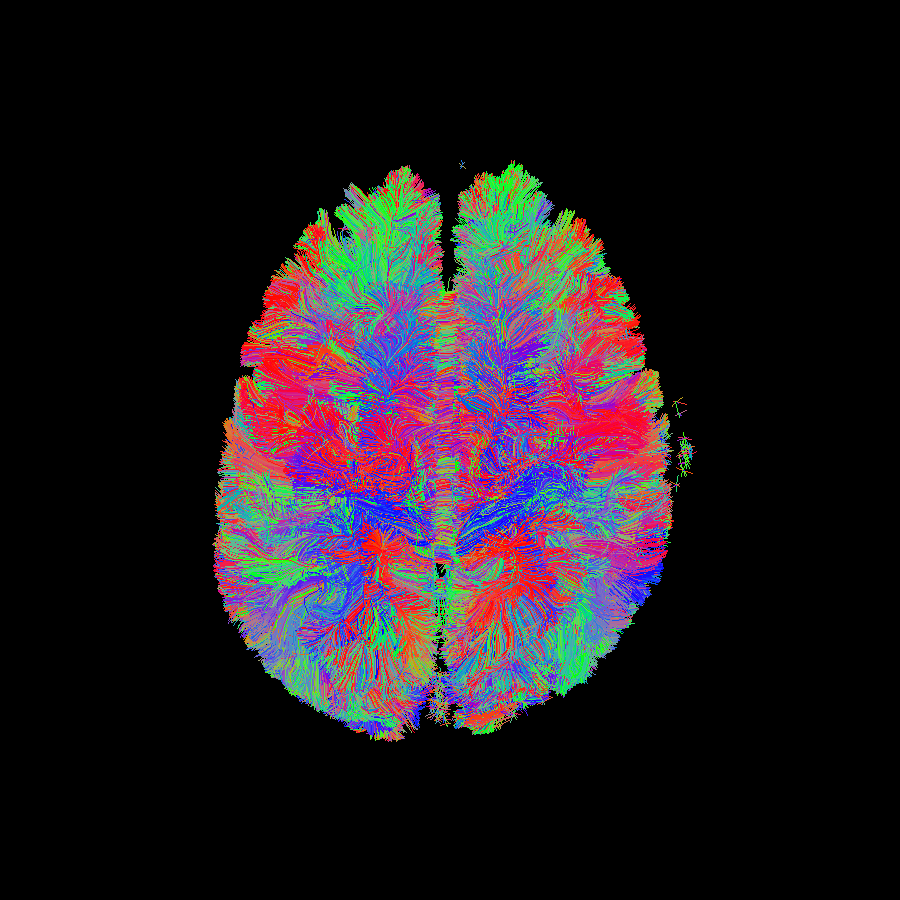

In [30]:
Image(show_sls(streamlines, out_path='ohbm_dipy_streamlines.png', interact=False))

This streamline dataset contains many streamlines that we are not interested in... there is sometimes a shell of short streamlines around the periphery of the brain that we know are an artifact of our tracking procedure... in this case we just have a few where the mask fit was poor... we can remove them with a length threshold

Text(0,0.5,'Count')

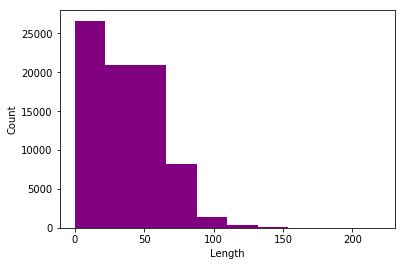

In [31]:
# Calculate the length of each streamline in the dataset
from dipy.tracking.utils import length

lengths = list(length(streamlines))

import matplotlib.pyplot as plt

fig_hist, ax = plt.subplots(1)
ax.hist(lengths, color='purple')
ax.set_xlabel('Length')
ax.set_ylabel('Count')

In [32]:
# Set a length threshold and make a new variable for long streamlines
length_threshold = 20
long_streamlines = [] # initialize an empty list
for i,sl in enumerate(streamlines):
    if lengths[i] > length_threshold:
        long_streamlines.append(sl)

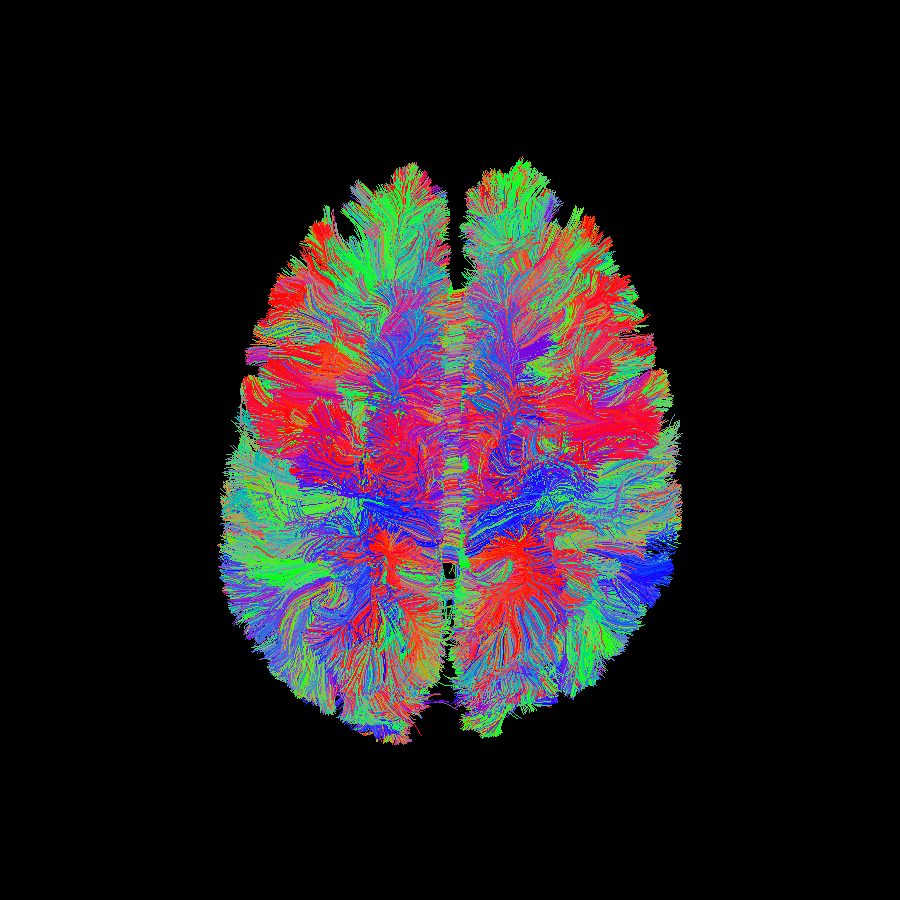

In [33]:
Image(show_sls(long_streamlines, out_path='ohbm_dipy_longsls.png'))

Save our new track

In [34]:
from nibabel.streamlines import save as save_trk
from nibabel.streamlines import Tractogram

save_trk(Tractogram(long_streamlines, affine_to_rasmm=img.affine),
         'ohbm_dipy_det_streamlines_long.trk')

# Cluster our results with Quickbundles

In [35]:
from dipy.segment.clustering import QuickBundles

In [36]:
qb = QuickBundles(threshold=12.)
clusters = qb.cluster(streamlines)
print(len(clusters), "Clusters")

231 Clusters


Let's take a look at the centroids...

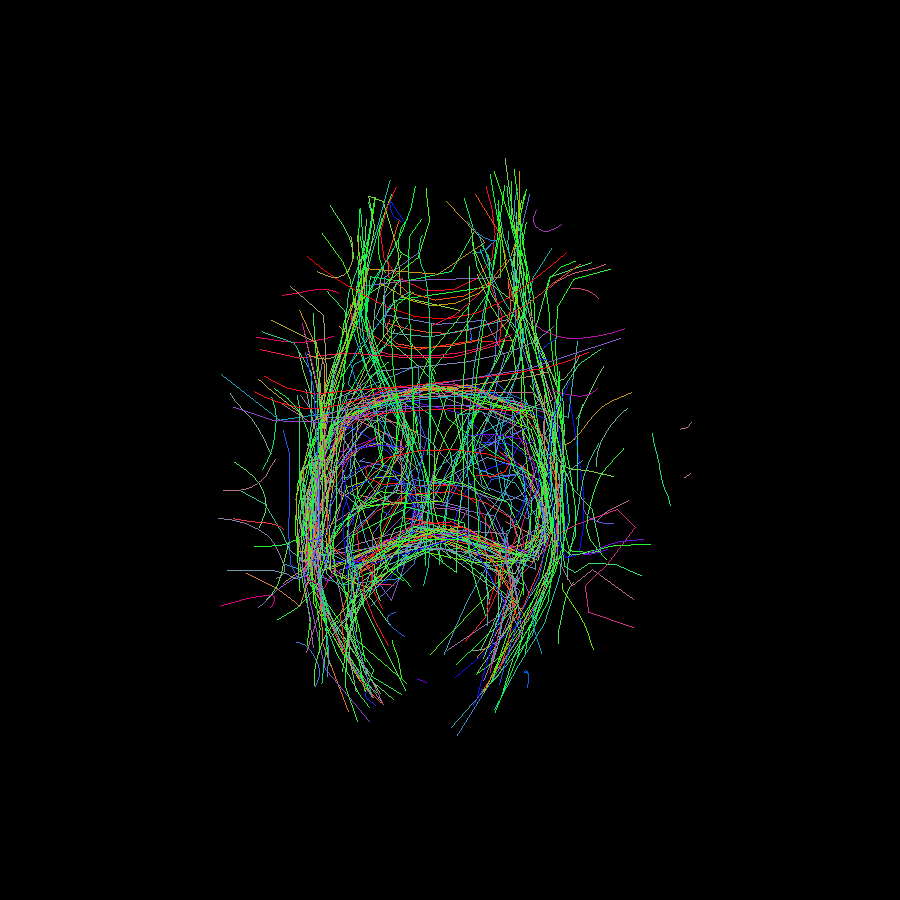

In [37]:
Image(show_sls(clusters.centroids, out_path='ohbm_dipy_qb.png'))